# Comp1-传统组学

主要适配于传统组学的建模和刻画。典型的应用场景探究rad_score最最终临床诊断的作用。

数据的一般形式为(具体文件,文件夹名可以不同)：
1. `images`文件夹，存放研究对象所有的CT、MRI等数据。
2. `masks`文件夹, 存放手工（Manuelly）勾画的ROI区域。与images文件夹的文件意义对应。
3. `label.txt`文件，每个患者对应的标签，例如肿瘤的良恶性、5年存活状态等。

## Onekey步骤

1. 数据校验，检查数据格式是否正确。
2. 组学特征提取，如果第一步检查数据通过，则提取对应数据的特征。
3. 读取标注数据信息。
4. 特征与标注数据拼接。形成数据集。
5. 查看一些统计信息，检查数据时候存在异常点。
6. 正则化，将数据变化到服从 N~(0, 1)。
7. 通过相关系数，例如spearman、person等筛选出特征。
8. 构建训练集和测试集，这里使用的是随机划分，正常多中心验证，需要大家根据自己的场景构建两份数据。
9. 通过Lasso筛选特征，选取其中的非0项作为后续模型的特征。
10. 使用机器学习算法，例如LR、SVM、RF等进行任务学习。
11. 模型结果可视化，例如AUC、ROC曲线，混淆矩阵等。


In [1]:
## 获得视频教程
import os
from onekey_algo.custom.Manager import onekey_show
onekey_show('传统组学任务')

[2025-03-25 12:09:39 - <frozen onekey_algo.custom.Manager>: 138]	INFO	播放视频功能已经设置成：Disable！


## 一、数据校验
首先需要检查诊断数据，如果显示`检查通过！`择可以正常运行之后的，否则请根据提示调整数据。

**注意**：这里要求images和masks文件夹中的文件名必须一一对应。e.g. `1.nii.gz`为images中的一个文件，在masks文件夹必须也存在一个`1.nii.gz`文件。

当然也可以使用自定义的函数，获取解析数据。

In [2]:
# 数据检验视频
onekey_show('传统组学任务|数据检验')

[2025-03-25 12:09:39 - <frozen onekey_algo.custom.Manager>: 138]	INFO	播放视频功能已经设置成：Disable！


### 指定数据

此模块有3个需要自己定义的参数

1. `mydir`: 数据存放的路径。
2. `labelf`: 每个样本的标注信息文件。
3. `labels`: 要让AI系统学习的目标，例如肿瘤的良恶性、T-stage等。

In [3]:
import os
import pandas as pd
from IPython.display import display
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('features', exist_ok=True)

# 设置任务Task前缀
task_type = 'Habitat_'
# 设置数据目录
# mydir = r'你自己数据的路径'
mydir = get_param_in_cwd('radio_dir')
if mydir == okds.ct:
    print(f'正在使用Onekey数据：{okds.ct}，如果不符合预期，请修改目录位置！')
# 对应的标签文件
group_info = get_param_in_cwd('dataset_column') or 'group'
labelf = get_param_in_cwd('label_file') or 'group.csv'
# 读取标签数据列名
labels = [get_param_in_cwd('task_column')] or ['label']

### images和masks匹配

这里要求images和masks文件夹中的文件名必须一一对应。e.g. `1.nii.gz`为images中的一个文件，在masks文件夹必须也存在一个`1.nii.gz`文件。

当然也可以使用自定义的函数，获取解析数据。

In [4]:
from pathlib import Path
from onekey_algo.custom.components.Radiology import diagnose_3d_image_mask_settings, get_image_mask_from_dir

# 生成images和masks对，一对一的关系。也可以自定义替换。
images, masks = get_image_mask_from_dir(mydir, images=f'images', masks=f'habitat')
# diagnose_3d_image_mask_settings(images, masks, verbose=False)
print(f'获取到{len(images)}个样本。')

获取到340个样本。


# 传统组学特征

使用pyradiomics提取传统组学特征，正常这块不需要修改，下面是具体的Onekey封装的接口。

```python
def extract(self, images: Union[str, List[str]], 
            masks: Union[str, List[str]], labels: Union[int, List[int]] = 1, settings=None)
"""
    * images: List结构，待提取的图像列表。
    * masks: List结构，待提取的图像对应的mask，与Images必须一一对应。
    * labels: 提取标注为什么标签的特征。默认为提取label=1的。
    * settings: 其他提取特征的参数。默认为None。

"""
```

```python
def get_label_data_frame(self, label: int = 1, column_names=None, images='images', masks='labels')
"""
    * label: 获取对应label的特征。
    * columns_names: 默认为None，使用程序设定的列名即可。
"""
```
    
```python
def get_image_mask_from_dir(root, images='images', masks='labels')
"""
    * root: 待提取特征的目录。
    * images: root目录中原始数据的文件夹名。
    * masks: root目录中标注数据的文件夹名。
"""
```


In [5]:
# 特征提取视频
onekey_show('传统组学任务|特征提取')

[2025-03-25 12:09:40 - <frozen onekey_algo.custom.Manager>: 138]	INFO	播放视频功能已经设置成：Disable！


In [6]:
import warnings
import pandas as pd
import numpy as np
from onekey_algo.custom.components.Radiology import ConventionalRadiomics
from onekey_algo.custom.components.habitat import habitat_feature_fusion
 
warnings.filterwarnings("ignore")

rad_data = None
habitats = get_param_in_cwd('habitats')
rad_ = []
param_file = get_param_in_cwd('extractor_settings')
for habitat in habitats:
    if os.path.exists(f'features/rad_features_h{habitat}.csv'):
        rad_data_ = pd.read_csv(f'features/rad_features_h{habitat}.csv', header=0)
    else:
        images, masks = get_image_mask_from_dir(mydir, images=f'images', masks=f'habitat')
        radiomics = ConventionalRadiomics(param_file, correctMask=True)
        radiomics.extract(images, masks, workers=6, labels=habitat)
        rad_data_ = radiomics.get_label_data_frame(label=habitat)
        rad_data_.columns = [f"{c.replace('-', '_')}_h{habitat}" if c != 'ID' else 'ID' for c in rad_data_.columns]
        rad_data_.to_csv(f'features/rad_features_h{habitat}.csv', header=True, index=False)
    rad_.append(rad_data_)

rad_data = habitat_feature_fusion(*rad_, mode=get_param_in_cwd('fusion_mode'))
rad_data.to_csv('features/rad_features.csv', index=False)
rad_data

[2025-03-25 12:09:40 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 12:09:40 - core.py: 188]	INFO	validation.valid
[2025-03-25 12:09:40 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 12:18:14 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 12:18:16 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 12:18:16 - core.py: 188]	INFO	validation.valid
[2025-03-25 12:18:16 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 12:26:41 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 12:26:43 - <frozen onekey_algo.custom.components.Radiology>: 578]	IN

[2025-03-25 15:03:17 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 15:03:17 - core.py: 188]	INFO	validation.valid
[2025-03-25 15:03:17 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 15:12:15 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 15:12:17 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 15:12:17 - core.py: 188]	INFO	validation.valid
[2025-03-25 15:12:17 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 15:22:21 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 15:22:22 - <frozen onekey_algo.custom.components.Radiology>: 578]	IN

[2025-03-25 17:51:11 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 17:51:11 - core.py: 188]	INFO	validation.valid
[2025-03-25 17:51:11 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 18:00:59 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 18:01:00 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 18:01:00 - core.py: 188]	INFO	validation.valid
[2025-03-25 18:01:00 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 18:10:30 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 18:10:32 - <frozen onekey_algo.custom.components.Radiology>: 578]	IN

[2025-03-25 20:43:45 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 20:43:45 - core.py: 188]	INFO	validation.valid
[2025-03-25 20:43:45 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 20:53:08 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 20:53:09 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 20:53:09 - core.py: 188]	INFO	validation.valid
[2025-03-25 20:53:09 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 21:02:31 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 21:02:32 - <frozen onekey_algo.custom.components.Radiology>: 578]	IN

[2025-03-25 23:37:48 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 23:37:48 - core.py: 188]	INFO	validation.valid
[2025-03-25 23:37:48 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 23:47:09 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 23:47:10 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-25 23:47:10 - core.py: 188]	INFO	validation.valid
[2025-03-25 23:47:10 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-25 23:56:49 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-25 23:56:50 - <frozen onekey_algo.custom.components.Radiology>: 578]	IN

[2025-03-26 02:23:54 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-26 02:23:54 - core.py: 188]	INFO	validation.valid
[2025-03-26 02:23:54 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-26 02:32:38 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-26 02:32:40 - <frozen onekey_algo.custom.components.Radiology>: 578]	INFO	使用E:\\111thymus\\thymus_habitat\\step1亚区分割特征提取聚类\\custom_settings\\exampleCT.yaml的配置文件。
[2025-03-26 02:32:40 - core.py: 188]	INFO	validation.valid
[2025-03-26 02:32:40 - <frozen onekey_algo.custom.components.Radiology>: 621]	INFO	Extracting features, 海森矩阵：False, 分形特征：False，拓扑学特征：False
[2025-03-26 02:41:03 - <frozen onekey_algo.custom.components.Radiology>: 705]	INFO	特征提取完成！
[2025-03-26 02:41:04 - <frozen onekey_algo.custom.components.Radiology>: 578]	IN

,ID,exponential_firstorder_10Percentile_h1,exponential_firstorder_90Percentile_h1,exponential_firstorder_Energy_h1,exponential_firstorder_Entropy_h1,exponential_firstorder_InterquartileRange_h1,exponential_firstorder_Kurtosis_h1,exponential_firstorder_Maximum_h1,exponential_firstorder_Mean_h1,exponential_firstorder_MeanAbsoluteDeviation_h1,...,wavelet_LLL_glszm_SmallAreaHighGrayLevelEmphasis_h100,wavelet_LLL_glszm_SmallAreaLowGrayLevelEmphasis_h100,wavelet_LLL_glszm_ZoneEntropy_h100,wavelet_LLL_glszm_ZonePercentage_h100,wavelet_LLL_glszm_ZoneVariance_h100,wavelet_LLL_ngtdm_Busyness_h100,wavelet_LLL_ngtdm_Coarseness_h100,wavelet_LLL_ngtdm_Complexity_h100,wavelet_LLL_ngtdm_Contrast_h100,wavelet_LLL_ngtdm_Strength_h100
0,1.nii.gz,1.086,5.089,4.114e+08,0.506,1.895,6.262,11.302,2.921,1.236,...,9673.529,4.008e-03,7.285,0.886,0.162,4.385e-03,2.120e-02,1.455e+05,2.117,257.919
1,10.nii.gz,1.397,47.715,1.539e+10,3.208,16.806,240.453,1630.037,21.507,22.282,...,250688.203,8.523e-05,9.158,0.962,0.042,4.074e-03,6.605e-04,1.326e+07,3.447,119.057
2,100.nii.gz,33.299,82.578,2.043e+09,3.934,23.657,6.249,181.426,55.350,15.694,...,454039.919,6.932e-04,8.798,0.918,0.114,3.716e-04,6.095e-03,6.994e+06,11.788,1899.824
3,101.nii.gz,5.062,33.785,7.518e+09,3.084,14.131,15.607,189.243,17.403,9.624,...,110930.499,5.129e-05,8.563,0.934,0.079,4.410e-03,1.557e-03,2.330e+06,1.815,103.652
4,102.nii.gz,4.953,25.092,8.697e+08,2.633,9.014,7.486,74.710,13.865,6.411,...,69032.510,1.342e-03,7.797,0.909,0.134,1.586e-03,9.821e-03,6.478e+05,2.833,337.174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,95.nii.gz,15.373,59.676,2.732e+09,3.719,21.247,13.829,238.587,35.240,14.528,...,981438.273,5.555e-04,8.709,0.902,0.128,3.771e-04,4.157e-03,9.806e+06,13.082,1760.022
336,96.nii.gz,3.707,32.945,6.330e+08,3.053,17.546,4.950,76.331,16.130,9.734,...,243896.102,1.539e-03,8.226,0.931,0.077,7.031e-04,1.203e-02,1.879e+06,7.612,941.789
337,97.nii.gz,9.634,132.920,3.894e+09,4.968,62.228,8.869,493.709,60.060,40.998,...,509364.087,2.826e-04,9.257,0.940,0.075,4.883e-04,3.449e-03,9.260e+06,4.789,1140.991
338,98.nii.gz,0.245,4.134,4.350e+08,0.456,2.242,37.147,32.189,2.316,1.708,...,269262.478,2.362e-03,7.820,0.914,0.118,8.726e-04,1.269e-02,1.686e+06,13.761,641.390


## 特征统计

,feature_group,count
1,firstorder,39600
0,glcm,48400
4,gldm,30800
2,glrlm,35200
3,glszm,35200
5,ngtdm,11000
6,shape,1400


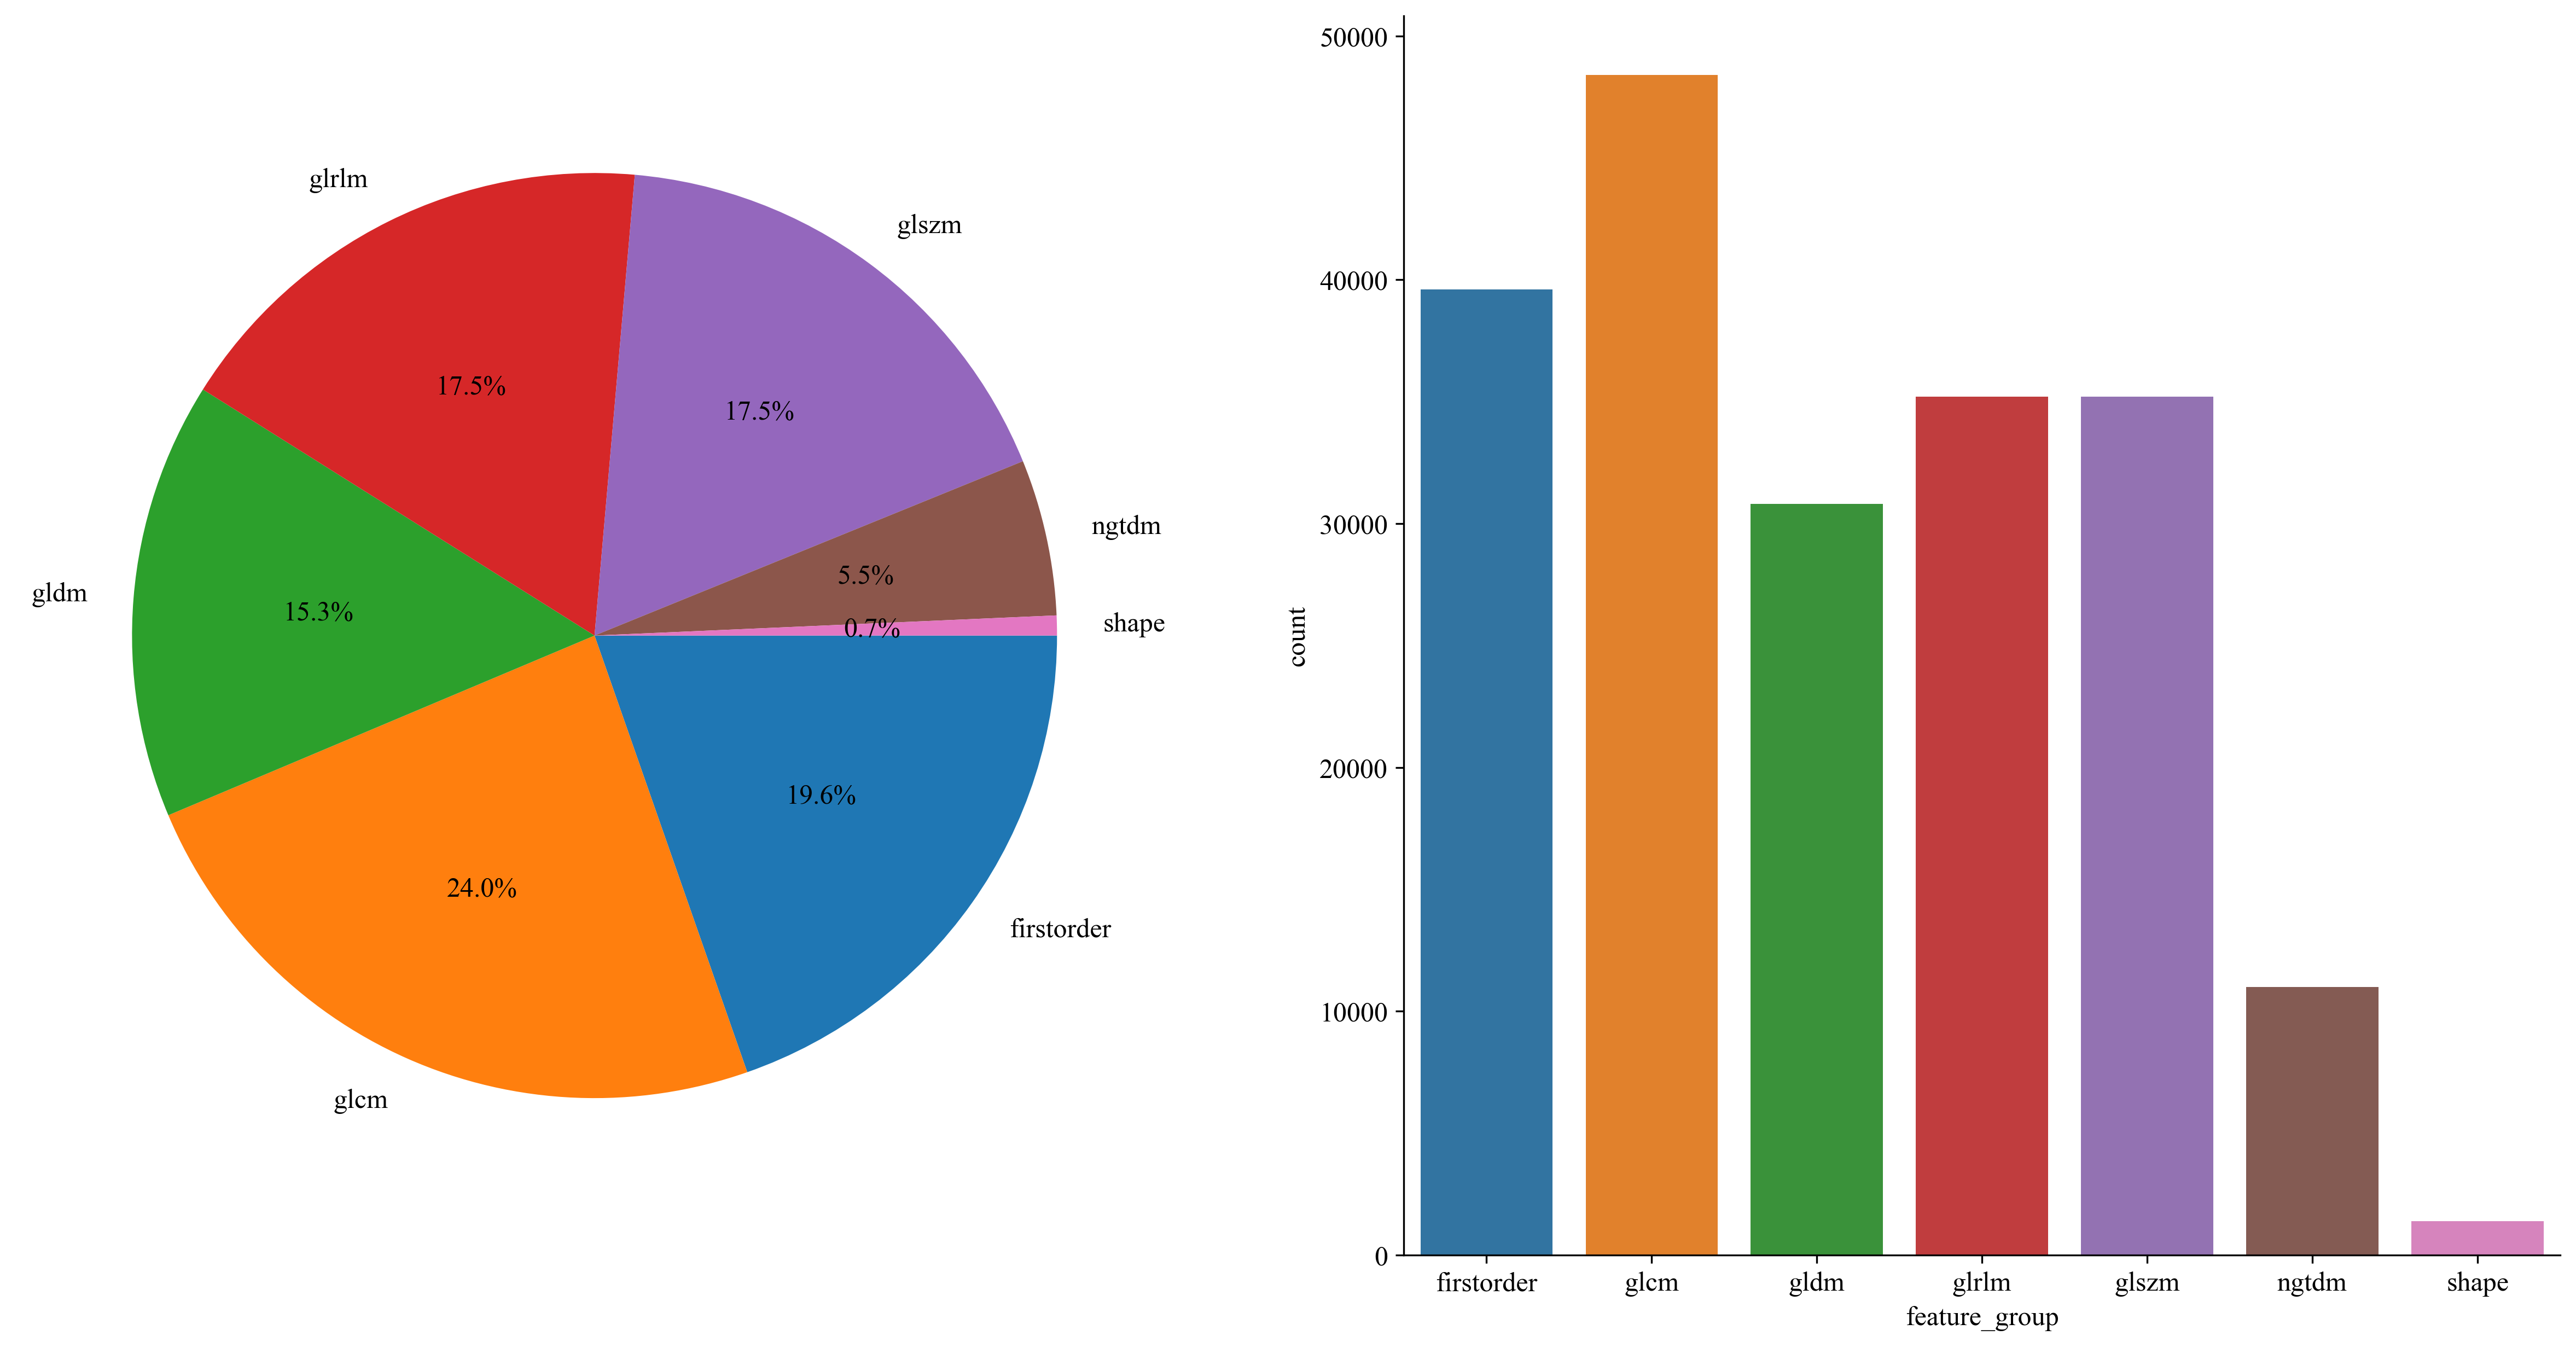

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sorted_counts = pd.DataFrame([c.split('_')[-3] for c in rad_data.columns if c !='ID']).value_counts()
sorted_counts = pd.DataFrame(sorted_counts, columns=['count']).reset_index()
sorted_counts = sorted_counts.sort_values(0)
sorted_counts.columns = ['feature_group', 'count']
display(sorted_counts)

plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
plt.pie(sorted_counts['count'], labels=[i for i in sorted_counts['feature_group']], startangle=0,
        counterclock = False, autopct = '%.1f%%')
# plt.bar_label(bar.containers[0])
ax = plt.subplot(122)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
bar = sns.barplot(data=sorted_counts, x='feature_group', y='count', )
plt.savefig(f'img/{task_type}feature_ratio.svg', bbox_inches = 'tight')

## 标注数据

数据以csv格式进行存储，这里如果是其他格式，可以使用自定义函数读取出每个样本的结果。

要求label_data为一个`DataFrame`格式，包括ID列以及后续的labels列，可以是多列，支持Multi-Task。

In [8]:
group_info = 'group'
label_data = pd.read_csv(labelf)
label_data['ID'] = label_data['ID'].map(lambda x: f"{x}.nii.gz" if not (f"{x}".endswith('.nii.gz') or  f"{x}".endswith('.nii')) else x)
label_data = label_data[['ID', group_info] + labels]
label_data

,ID,group,label
0,1.nii.gz,train,1
1,2.nii.gz,train,1
2,3.nii.gz,train,1
3,4.nii.gz,train,1
4,5.nii.gz,train,1
...,...,...,...
335,453.nii.gz,test2,0
336,454.nii.gz,test2,0
337,455.nii.gz,test2,0
338,457.nii.gz,test2,1


## 特征拼接 

将标注数据`label_data`与`rad_data`进行合并，得到训练数据。

**注意：** 
1. 需要删掉ID这一列
2. 如果发现数据少了，需要自行检查数据是否匹配。

In [9]:
# 删掉ID这一列。
from onekey_algo.custom.utils import print_join_info
print_join_info(rad_data, label_data)
combined_data = pd.merge(rad_data, label_data, on=['ID'], how='inner')
# combined_data[['ID'] + selected_features[0]].to_csv('features/sel_habitat.csv', index=False)
ids = combined_data['ID']
combined_data = combined_data.drop(['ID'], axis=1)
display(combined_data[labels].value_counts())
display(combined_data[group_info].value_counts())
combined_data

[2025-03-26 03:56:05 - <frozen onekey_algo.custom.utils>:  57]	INFO	ID特征完全匹配！


label
1        233
0        107
dtype: int64

train    205
test1     87
test2     48
Name: group, dtype: int64

,exponential_firstorder_10Percentile_h1,exponential_firstorder_90Percentile_h1,exponential_firstorder_Energy_h1,exponential_firstorder_Entropy_h1,exponential_firstorder_InterquartileRange_h1,exponential_firstorder_Kurtosis_h1,exponential_firstorder_Maximum_h1,exponential_firstorder_Mean_h1,exponential_firstorder_MeanAbsoluteDeviation_h1,exponential_firstorder_Median_h1,...,wavelet_LLL_glszm_ZoneEntropy_h100,wavelet_LLL_glszm_ZonePercentage_h100,wavelet_LLL_glszm_ZoneVariance_h100,wavelet_LLL_ngtdm_Busyness_h100,wavelet_LLL_ngtdm_Coarseness_h100,wavelet_LLL_ngtdm_Complexity_h100,wavelet_LLL_ngtdm_Contrast_h100,wavelet_LLL_ngtdm_Strength_h100,group,label
0,1.086,5.089,4.114e+08,0.506,1.895,6.262,11.302,2.921,1.236,2.642,...,7.285,0.886,0.162,4.385e-03,2.120e-02,1.455e+05,2.117,257.919,train,1
1,1.397,47.715,1.539e+10,3.208,16.806,240.453,1630.037,21.507,22.282,8.164,...,9.158,0.962,0.042,4.074e-03,6.605e-04,1.326e+07,3.447,119.057,train,1
2,33.299,82.578,2.043e+09,3.934,23.657,6.249,181.426,55.350,15.694,50.875,...,8.798,0.918,0.114,3.716e-04,6.095e-03,6.994e+06,11.788,1899.824,train,0
3,5.062,33.785,7.518e+09,3.084,14.131,15.607,189.243,17.403,9.624,14.068,...,8.563,0.934,0.079,4.410e-03,1.557e-03,2.330e+06,1.815,103.652,train,0
4,4.953,25.092,8.697e+08,2.633,9.014,7.486,74.710,13.865,6.411,12.296,...,7.797,0.909,0.134,1.586e-03,9.821e-03,6.478e+05,2.833,337.174,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,15.373,59.676,2.732e+09,3.719,21.247,13.829,238.587,35.240,14.528,30.289,...,8.709,0.902,0.128,3.771e-04,4.157e-03,9.806e+06,13.082,1760.022,train,0
336,3.707,32.945,6.330e+08,3.053,17.546,4.950,76.331,16.130,9.734,12.995,...,8.226,0.931,0.077,7.031e-04,1.203e-02,1.879e+06,7.612,941.789,train,1
337,9.634,132.920,3.894e+09,4.968,62.228,8.869,493.709,60.060,40.998,44.335,...,9.257,0.940,0.075,4.883e-04,3.449e-03,9.260e+06,4.789,1140.991,train,1
338,0.245,4.134,4.350e+08,0.456,2.242,37.147,32.189,2.316,1.708,1.788,...,7.820,0.914,0.118,8.726e-04,1.269e-02,1.686e+06,13.761,641.390,train,0


## 获取到数据的统计信息

1. count，统计样本个数。
2. mean、std, 对应特征的均值、方差
3. min, 25%, 50%, 75%, max，对应特征的最小值，25,50,75分位数，最大值。

In [10]:
combined_data.describe()

,exponential_firstorder_10Percentile_h1,exponential_firstorder_90Percentile_h1,exponential_firstorder_Energy_h1,exponential_firstorder_Entropy_h1,exponential_firstorder_InterquartileRange_h1,exponential_firstorder_Kurtosis_h1,exponential_firstorder_Maximum_h1,exponential_firstorder_Mean_h1,exponential_firstorder_MeanAbsoluteDeviation_h1,exponential_firstorder_Median_h1,...,wavelet_LLL_glszm_SmallAreaLowGrayLevelEmphasis_h100,wavelet_LLL_glszm_ZoneEntropy_h100,wavelet_LLL_glszm_ZonePercentage_h100,wavelet_LLL_glszm_ZoneVariance_h100,wavelet_LLL_ngtdm_Busyness_h100,wavelet_LLL_ngtdm_Coarseness_h100,wavelet_LLL_ngtdm_Complexity_h100,wavelet_LLL_ngtdm_Contrast_h100,wavelet_LLL_ngtdm_Strength_h100,label
count,340.000,340.000,3.400e+02,3.400e+02,340.000,340.000,340.000,340.000,340.000,340.000,...,3.400e+02,340.000,340.000,340.000,3.400e+02,3.400e+02,3.400e+02,340.000,340.000,340.000
mean,7.931,63.320,2.424e+09,3.088e+00,23.944,57.037,390.180,31.664,21.015,22.697,...,3.297e-03,8.041,0.930,0.092,2.588e-03,9.710e-03,4.229e+06,112.600,890.737,0.685
std,10.207,125.021,4.143e+09,1.232e+00,29.865,187.579,538.841,38.884,39.871,24.935,...,7.566e-03,0.992,0.029,0.049,4.767e-03,8.766e-03,5.987e+06,819.306,771.242,0.465
min,0.021,1.844,1.804e+07,-3.203e-16,0.621,1.519,2.184,1.065,0.593,0.304,...,3.580e-05,3.700,0.836,0.000,1.930e-04,3.289e-04,2.536e+03,1.097,41.300,0.000
25%,2.170,20.592,4.417e+08,2.320e+00,8.403,6.115,69.662,11.376,5.993,8.473,...,5.025e-04,7.565,0.913,0.060,5.939e-04,4.432e-03,8.456e+05,2.899,327.823,0.000
50%,4.946,39.232,1.114e+09,3.217e+00,16.056,10.783,155.077,21.459,11.327,15.458,...,1.163e-03,8.224,0.929,0.087,1.150e-03,8.378e-03,2.142e+06,6.093,704.715,1.000
75%,9.459,67.231,2.759e+09,3.911e+00,26.932,27.276,401.146,36.221,20.913,27.259,...,2.894e-03,8.694,0.951,0.117,2.625e-03,1.269e-02,5.082e+06,17.199,1233.846,1.000
max,78.339,1947.952,3.797e+10,6.050e+00,290.102,2701.487,2563.806,378.625,535.549,190.748,...,7.698e-02,10.065,1.000,0.418,4.991e-02,8.943e-02,5.565e+07,13371.580,5398.471,1.000


## 正则化

`normalize_df` 为onekey中正则化的API，将数据变化到0均值1方差。正则化的方法为

$column = \frac{column - mean}{std}$

In [11]:
from onekey_algo.custom.components.comp1 import normalize_df
data = normalize_df(combined_data, not_norm=labels, group=group_info, use_train=True, verbose=True)
data = data.dropna(axis=1)
data.describe()

[2025-03-26 03:59:23 - <frozen onekey_algo.custom.components.comp1>: 192]	INFO	正在使用训练集预定数据进行标准化。


,exponential_firstorder_10Percentile_h1,exponential_firstorder_90Percentile_h1,exponential_firstorder_Energy_h1,exponential_firstorder_Entropy_h1,exponential_firstorder_InterquartileRange_h1,exponential_firstorder_Kurtosis_h1,exponential_firstorder_Maximum_h1,exponential_firstorder_Mean_h1,exponential_firstorder_MeanAbsoluteDeviation_h1,exponential_firstorder_Median_h1,...,wavelet_LLL_glszm_SmallAreaLowGrayLevelEmphasis_h100,wavelet_LLL_glszm_ZoneEntropy_h100,wavelet_LLL_glszm_ZonePercentage_h100,wavelet_LLL_glszm_ZoneVariance_h100,wavelet_LLL_ngtdm_Busyness_h100,wavelet_LLL_ngtdm_Coarseness_h100,wavelet_LLL_ngtdm_Complexity_h100,wavelet_LLL_ngtdm_Contrast_h100,wavelet_LLL_ngtdm_Strength_h100,label
count,340.000,340.000,340.000,340.000,340.000,340.000,340.000,340.000,340.000,340.000,...,340.000,340.000,340.000,340.000,340.000,340.000,340.000,340.000,340.000,340.000
mean,-0.144,-0.047,-0.149,-0.294,-0.049,-0.065,-0.184,-0.100,-0.052,-0.117,...,0.848,-0.410,0.103,-0.068,0.418,0.335,-0.118,2.442,0.115,0.685
std,0.979,0.883,0.960,1.169,1.271,0.824,0.910,1.042,0.944,1.061,...,3.527,1.428,1.156,1.226,2.549,1.516,0.861,20.407,1.050,0.465
min,-0.903,-0.481,-0.707,-3.224,-1.041,-0.309,-0.839,-0.920,-0.535,-1.070,...,-0.673,-6.658,-3.657,-2.362,-0.862,-1.287,-0.726,-0.336,-1.041,0.000
25%,-0.696,-0.349,-0.609,-1.022,-0.710,-0.289,-0.725,-0.644,-0.408,-0.723,...,-0.456,-1.096,-0.596,-0.871,-0.648,-0.578,-0.605,-0.291,-0.651,0.000
50%,-0.430,-0.217,-0.453,-0.172,-0.384,-0.268,-0.581,-0.374,-0.281,-0.425,...,-0.148,-0.146,0.051,-0.176,-0.351,0.105,-0.419,-0.211,-0.138,1.000
75%,0.003,-0.020,-0.072,0.487,0.079,-0.196,-0.165,0.022,-0.055,0.077,...,0.660,0.530,0.926,0.565,0.438,0.851,0.004,0.065,0.582,1.000
max,6.613,13.260,8.088,2.516,11.281,11.548,3.487,9.199,12.127,7.035,...,35.202,2.504,2.908,8.111,25.724,14.125,7.277,332.689,6.249,1.000


## 统计检验

通过ttest或者utest进行特征筛选。

**注意** ：此步骤不是论文的标配，所以用不用在自己的选择，可以通过修改pvalue的值进行调整，默认是0.05为显著。

In [12]:
import seaborn as sns
from onekey_algo.custom.components.stats import clinic_stats

sub_data = data[data[group_info] == 'train']
stats = clinic_stats(sub_data, stats_columns=list(data.columns[0:-2]), label_column=labels[0], 
                     continuous_columns=list(data.columns[0:-2]))
stats

,feature_name,-label=ALL,-label=0,-label=1,pvalue
0,exponential_firstorder_10Percentile_h1,-0.00±1.00,0.25±1.34,-0.11±0.79,0.042
1,exponential_firstorder_90Percentile_h1,0.00±1.00,0.10±0.48,-0.04±1.15,<0.001
2,exponential_firstorder_Energy_h1,0.00±1.00,0.21±1.36,-0.09±0.79,0.327
3,exponential_firstorder_Entropy_h1,0.00±1.00,0.39±1.03,-0.16±0.94,<0.001
4,exponential_firstorder_InterquartileRange_h1,0.00±1.00,0.40±1.24,-0.17±0.83,<0.001
...,...,...,...,...,...
201557,wavelet_LLL_ngtdm_Busyness_h100,-0.00±1.00,0.13±1.28,-0.06±0.86,0.627
201558,wavelet_LLL_ngtdm_Coarseness_h100,0.00±1.00,-0.04±1.08,0.02±0.97,0.349
201559,wavelet_LLL_ngtdm_Complexity_h100,0.00±1.00,0.04±1.04,-0.02±0.99,0.925
201560,wavelet_LLL_ngtdm_Contrast_h100,-0.00±1.00,0.04±1.09,-0.02±0.97,0.165


#### 输出特征分布的图

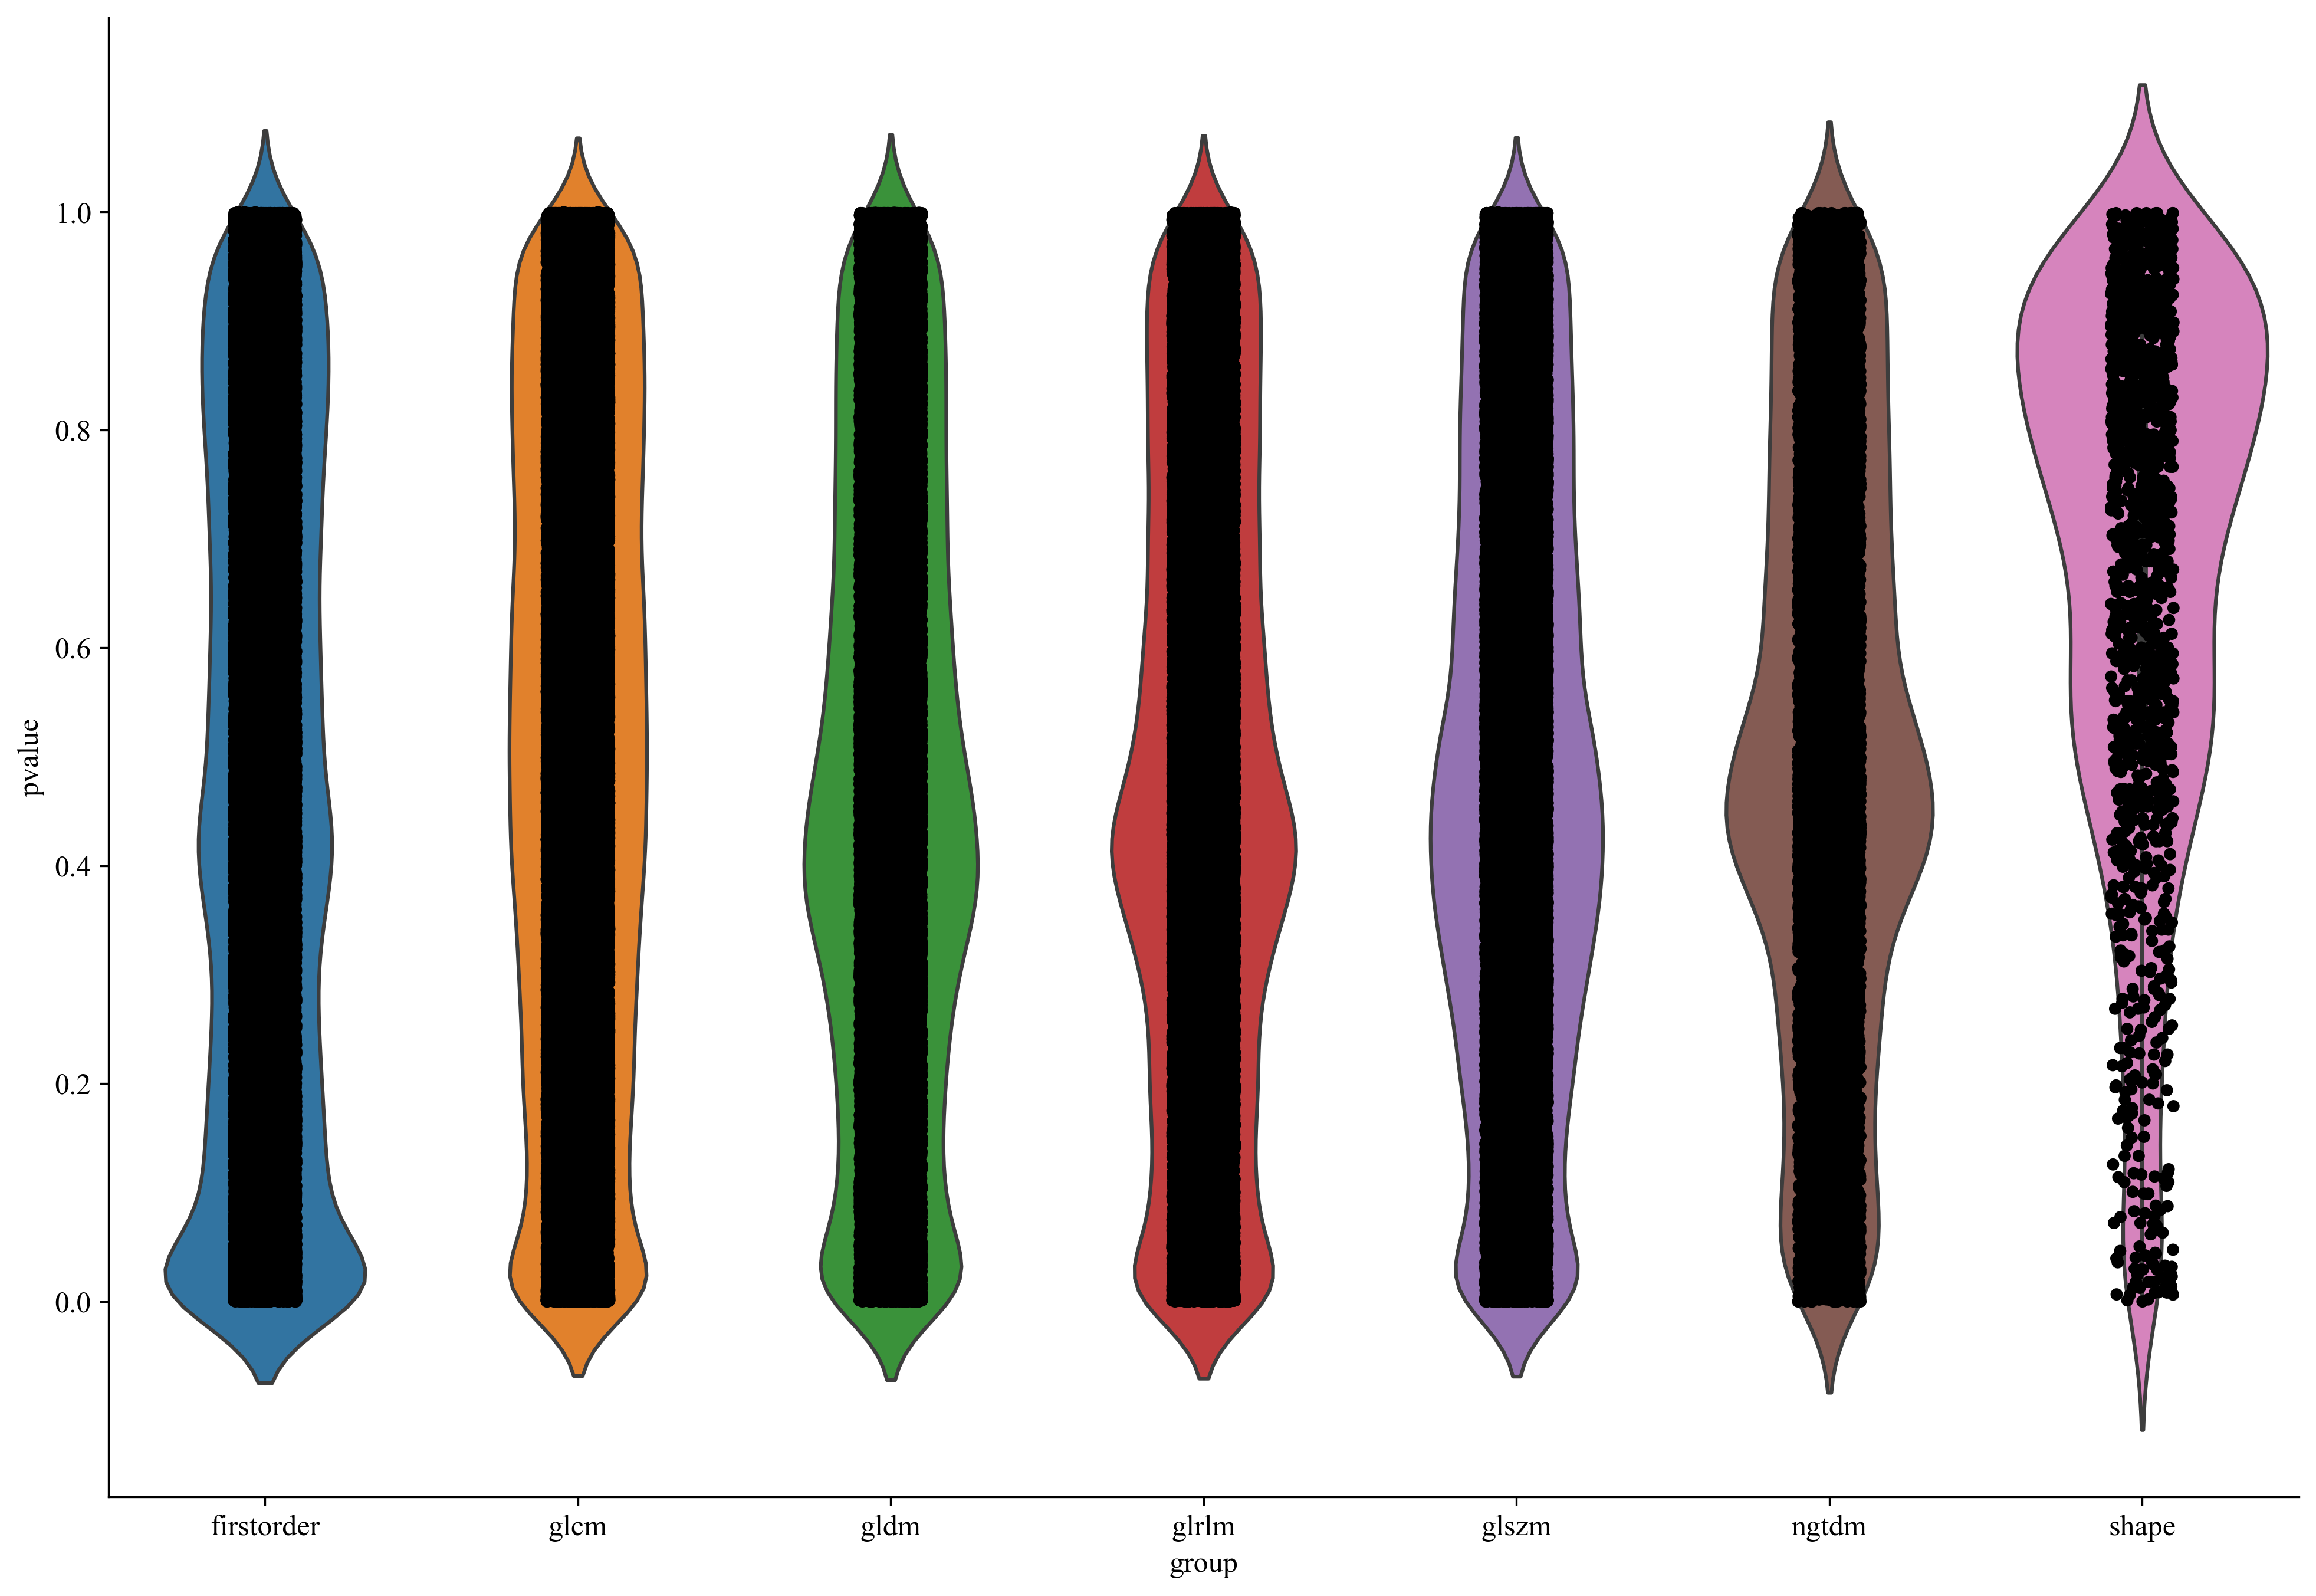

In [13]:
import matplotlib.pyplot as plt

def map2float(x):
    try:
        return float(str(x)[1:])
    except:
        return 1

stats[['pvalue']] = stats[['pvalue']].applymap(map2float)
stats[['group']] = stats[['feature_name']].applymap(lambda x: x.split('_')[-3])
stats = stats[['feature_name', 'pvalue', 'group']]
g = sns.catplot(x="group", y="pvalue", data=stats, kind="violin")
g.fig.set_size_inches(15,10)
sns.stripplot(x="group", y="pvalue", data=stats, ax=g.ax, color='black')
plt.savefig(f'img/{task_type}Rad_feature_stats.svg', bbox_inches = 'tight')

#### 调整pvalue进行筛选。

In [14]:
pvalue = 0.05
sel_feature = list(stats[stats['pvalue'] < pvalue]['feature_name']) + labels + [group_info]
sub_data = sub_data[sel_feature]
sub_data

,exponential_firstorder_10Percentile_h1,exponential_firstorder_90Percentile_h1,exponential_firstorder_Entropy_h1,exponential_firstorder_InterquartileRange_h1,exponential_firstorder_Mean_h1,exponential_firstorder_MeanAbsoluteDeviation_h1,exponential_firstorder_Median_h1,exponential_firstorder_RobustMeanAbsoluteDeviation_h1,exponential_firstorder_RootMeanSquared_h1,exponential_firstorder_Uniformity_h1,...,wavelet_HLH_firstorder_Maximum_h100,wavelet_LLH_firstorder_Mean_h100,wavelet_LLH_firstorder_RootMeanSquared_h100,wavelet_LLL_firstorder_10Percentile_h100,wavelet_LLL_firstorder_90Percentile_h100,wavelet_LLL_firstorder_Mean_h100,wavelet_LLL_firstorder_Median_h100,wavelet_LLL_firstorder_RootMeanSquared_h100,label,group
0,-0.800,-0.459,-2.744,-0.987,-0.870,-0.520,-0.971,-0.311,-0.734,5.059,...,-0.687,-0.149,-0.404,0.700,-0.240,0.247,0.133,0.147,1,train
1,-0.771,-0.158,-0.180,-0.352,-0.372,-0.022,-0.736,-0.127,-0.315,0.277,...,4.411,0.260,1.850,-0.482,-0.264,-0.492,-0.574,-0.541,1,train
2,2.291,0.089,0.509,-0.061,0.535,-0.178,1.082,-0.071,0.366,-0.601,...,-0.385,-0.257,-0.416,-1.109,0.459,0.244,0.854,0.382,0,train
3,-0.419,-0.256,-0.297,-0.466,-0.482,-0.322,-0.485,-0.180,-0.429,-0.074,...,-0.399,0.135,-0.169,0.292,-0.153,0.072,-0.002,-0.014,0,train
4,-0.429,-0.317,-0.726,-0.684,-0.577,-0.398,-0.560,-0.230,-0.504,0.295,...,-0.783,0.079,-0.245,0.710,-0.058,0.429,0.399,0.353,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.571,-0.073,0.305,-0.163,-0.004,-0.206,0.206,-0.104,-0.054,-0.483,...,0.588,-0.719,-0.328,0.326,0.074,-0.015,0.154,0.107,0,train
336,-0.549,-0.262,-0.327,-0.321,-0.516,-0.319,-0.530,-0.160,-0.456,-0.138,...,-0.743,-0.057,-0.321,0.402,0.450,0.430,0.328,0.405,1,train
337,0.020,0.444,1.490,1.581,0.661,0.421,0.804,0.332,0.491,-0.911,...,0.051,0.140,-0.155,-0.586,0.707,0.390,0.767,0.495,1,train
338,-0.881,-0.465,-2.791,-0.972,-0.887,-0.509,-1.007,-0.308,-0.747,5.537,...,0.549,-4.476,-1.491,0.849,0.493,0.694,0.656,0.667,0,train


### 相关系数

计算相关系数的方法有3种可供选择
1. pearson （皮尔逊相关系数）: standard correlation coefficient

2. kendall (肯德尔相关性系数) : Kendall Tau correlation coefficient

3. spearman (斯皮尔曼相关性系数): Spearman rank correlation

三种相关系数参考：https://blog.csdn.net/zmqsdu9001/article/details/82840332

In [15]:
# 相关系数视频
onekey_show('传统组学任务|相关系数')

[2025-03-26 17:45:42 - <frozen onekey_algo.custom.Manager>: 138]	INFO	播放视频功能已经设置成：Disable！


In [16]:
pearson_corr = sub_data[[c for c in sub_data.columns if c not in labels]].corr('pearson')
# kendall_corr = data[[c for c in data.columns if c not in labels]].corr('kendall')
# spearman_corr = data[[c for c in data.columns if c not in labels]].corr('spearman')

### 相关系数可视化

通过修改变量名，可以可视化不同相关系数下的相关矩阵。

**注意**：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

In [17]:
import seaborn as sns
from onekey_algo.custom.components.comp1 import draw_matrix

if data.shape[1] < 100:
    plt.figure(figsize=(50.0, 40.0))

    # 选择可视化的相关系数
    draw_matrix(pearson_corr, annot=True, cmap='YlGnBu', cbar=False)
    plt.savefig(f'img/{task_type}Rad_feature_corr.svg', bbox_inches = 'tight')

### 聚类分析

通过修改变量名，可以可视化不同相关系数下的相聚类分析矩阵。

注意：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

if data.shape[1] < 100:
    pp = sns.clustermap(pearson_corr, linewidths=.5, figsize=(50.0, 40.0), cmap='YlGnBu')
    plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
    plt.savefig(f'img/{task_type}Rad_feature_cluster.svg', bbox_inches = 'tight')

### 特征筛选 -- 相关系数

根据相关系数，对于相关性比较高的特征（一般文献取corr>0.9），两者保留其一。

```python
def select_feature(corr, threshold: float = 0.9, keep: int = 1, topn=10, verbose=False):
    """
    * corr, 相关系数矩阵。
    * threshold，筛选的相关系数的阈值，大于阈值的两者保留其一（可以根据keep修改，可以是其二...）。默认阈值为0.9
    * keep，可以选择大于相关系数，保留几个，默认只保留一个。
    * topn, 每次去掉多少重复特征。
    * verbose，是否打印日志
    """
```

In [19]:
# 特征筛选视频
onekey_show('传统组学任务|特征筛选')

[2025-03-26 17:47:43 - <frozen onekey_algo.custom.Manager>: 138]	INFO	播放视频功能已经设置成：Disable！


In [21]:
# import math
# from onekey_algo.custom.components.comp1 import select_feature, select_feature_mrmr

# sel_feature = select_feature(pearson_corr, threshold=0.9, topn=16, verbose=False)
# mrmr_sel_feature_num = get_param_in_cwd('mrmr_sel_feature_num')
# if mrmr_sel_feature_num is not None:
#     sel_feature = select_feature_mrmr(sub_data[sel_feature + labels], num_features=mrmr_sel_feature_num)
# sel_feature += labels + [group_info]
# sel_feature

### 过滤特征

通过`sel_feature`过滤出筛选出来的特征。

In [22]:
sel_data = data[sel_feature]
sel_data

,exponential_firstorder_10Percentile_h1,exponential_firstorder_90Percentile_h1,exponential_firstorder_Entropy_h1,exponential_firstorder_InterquartileRange_h1,exponential_firstorder_Mean_h1,exponential_firstorder_MeanAbsoluteDeviation_h1,exponential_firstorder_Median_h1,exponential_firstorder_RobustMeanAbsoluteDeviation_h1,exponential_firstorder_RootMeanSquared_h1,exponential_firstorder_Uniformity_h1,...,wavelet_HLH_firstorder_Maximum_h100,wavelet_LLH_firstorder_Mean_h100,wavelet_LLH_firstorder_RootMeanSquared_h100,wavelet_LLL_firstorder_10Percentile_h100,wavelet_LLL_firstorder_90Percentile_h100,wavelet_LLL_firstorder_Mean_h100,wavelet_LLL_firstorder_Median_h100,wavelet_LLL_firstorder_RootMeanSquared_h100,label,group
125,-0.605,0.360,0.523,0.504,0.226,0.464,-0.207,0.179,0.163,-0.531,...,-0.968,-0.481,-0.408,-1.986,-2.091,-2.292,-2.235,-2.384,0,test1
126,1.152,2.613,0.607,5.046,3.045,2.675,1.555,1.766,2.592,-0.738,...,-0.329,2.205,1.135,-1.226,0.002,-0.814,-0.930,-0.687,0,test1
127,0.572,4.730,2.202,11.281,6.244,5.896,3.680,2.878,6.041,-1.043,...,0.890,-0.607,0.161,-0.356,0.427,0.009,0.002,0.089,0,test1
128,-0.677,-0.027,0.302,0.200,-0.248,-0.039,-0.411,-0.029,-0.239,-0.354,...,-0.592,-1.167,-0.692,-0.544,0.757,0.453,0.826,0.557,0,test1
129,0.195,1.473,2.063,3.545,2.100,1.871,1.285,0.946,1.856,-0.991,...,1.460,-0.743,-0.264,-0.237,0.537,-0.037,-0.044,0.101,0,test1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.571,-0.073,0.305,-0.163,-0.004,-0.206,0.206,-0.104,-0.054,-0.483,...,0.588,-0.719,-0.328,0.326,0.074,-0.015,0.154,0.107,0,train
336,-0.549,-0.262,-0.327,-0.321,-0.516,-0.319,-0.530,-0.160,-0.456,-0.138,...,-0.743,-0.057,-0.321,0.402,0.450,0.430,0.328,0.405,1,train
337,0.020,0.444,1.490,1.581,0.661,0.421,0.804,0.332,0.491,-0.911,...,0.051,0.140,-0.155,-0.586,0.707,0.390,0.767,0.495,1,train
338,-0.881,-0.465,-2.791,-0.972,-0.887,-0.509,-1.007,-0.308,-0.747,5.537,...,0.549,-4.476,-1.491,0.849,0.493,0.694,0.656,0.667,0,train


### 样本可视化

根据特征和label信息，将rad features降维到2维，看不同的label样本在二维空间的分布。

**注意**：由于特征空间维度极高，降维难免会有损失，所以二维的可视化仅供参考。

目前支持的:

| **降维方法** | **Method名称**                                                 |
| ------------ | ------------------------------------------------------------ |
| LLE      | Standard LLE, Modified LLE                                   |
| PCA      | t-SNE, NCA                                                      |
| SVD      | Truncated SVD                                              |
| Model Based      | Random projection, Isomap, MDS, Random Trees,Spectral       |

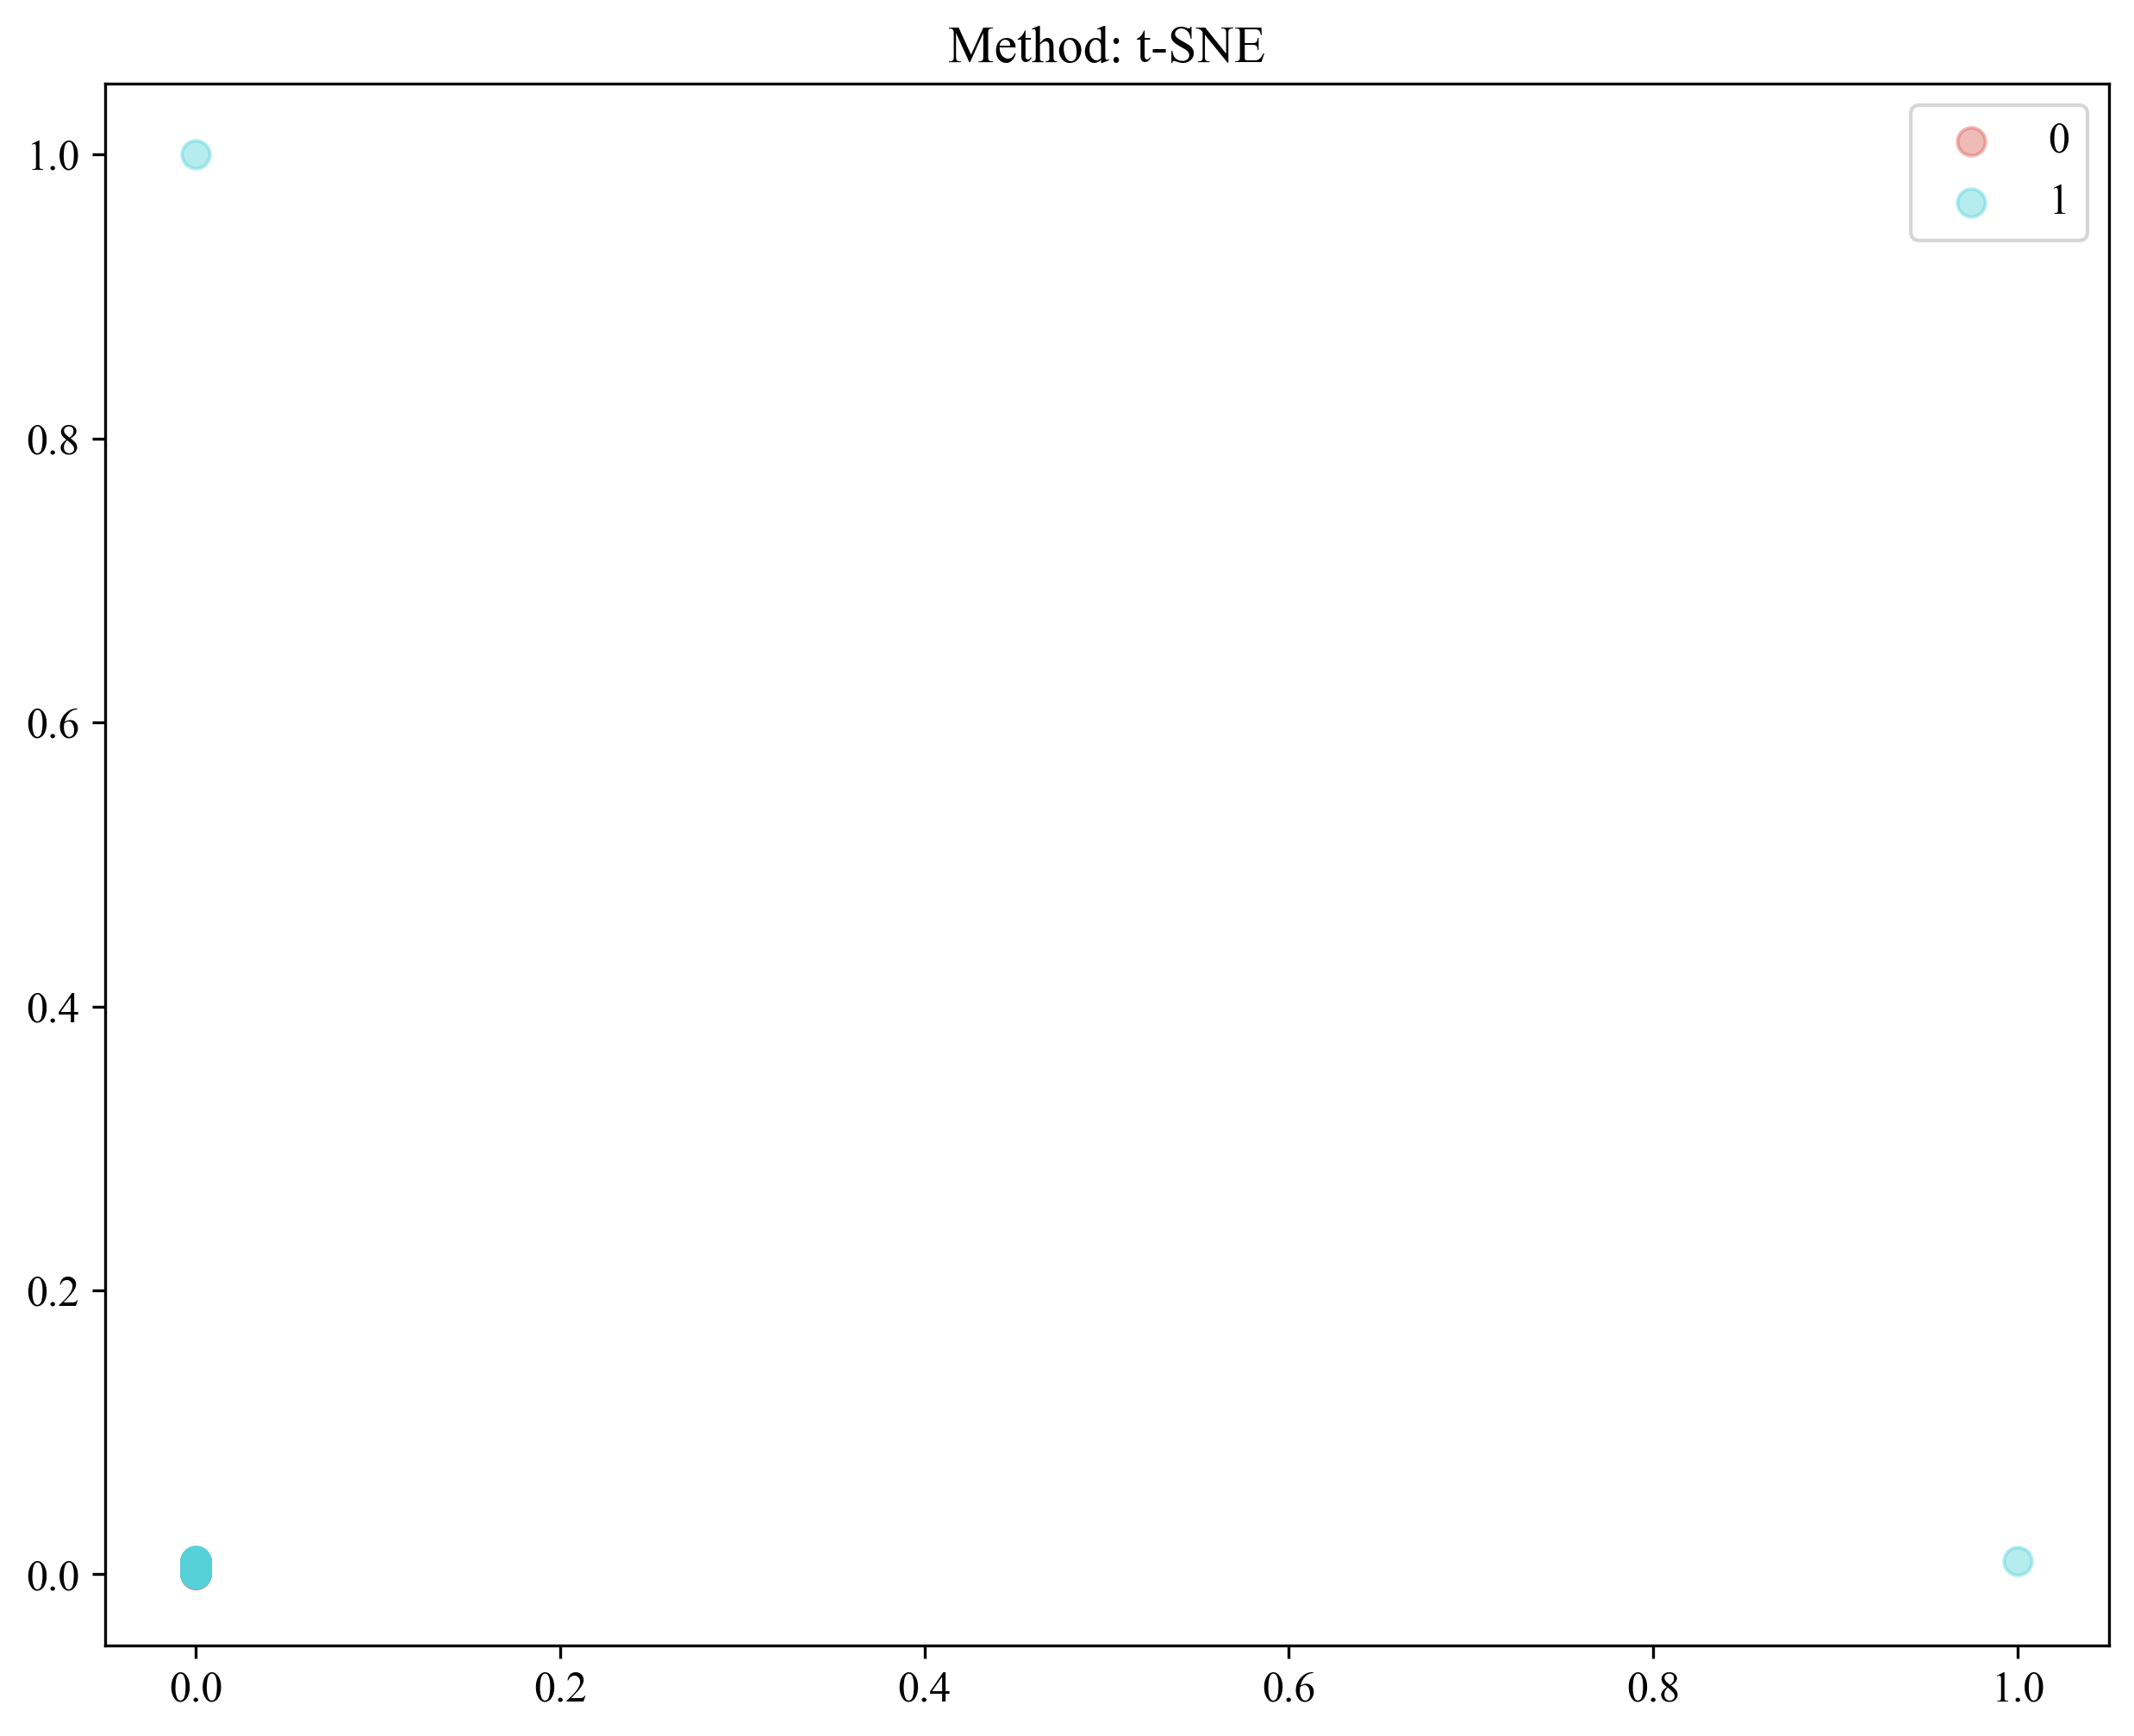

In [23]:
from onekey_algo.custom.components.comp1 import analysis_features
analysis_features(data[sel_feature[:-3]], data[labels[0]], methods='t-SNE')

## 构建数据

将样本的训练数据X与监督信息y分离出来，并且对训练数据进行划分，一般的划分原则为80%-20%

In [24]:
import numpy as np
import onekey_algo.custom.components as okcomp

n_classes = 2
train_data = sel_data[(sel_data[group_info] == 'train')]
train_ids = ids[train_data.index]
train_data = train_data.reset_index()
train_data = train_data.drop('index', axis=1)
y_data = train_data[labels]
X_data = train_data.drop(labels + [group_info], axis=1)

val_data = sel_data[sel_data[group_info] == 'val']
val_ids = ids[val_data.index]
val_data = val_data.reset_index()
val_data = val_data.drop('index', axis=1)
y_val_data = val_data[labels]
X_val_data = val_data.drop(labels + [group_info], axis=1)

test_data = sel_data[sel_data[group_info] == 'val']
test_ids = ids[test_data.index]
test_data = test_data.reset_index()
test_data = test_data.drop('index', axis=1)
y_test_data = test_data[labels]
X_test_data = test_data.drop(labels + [group_info], axis=1)

y_all_data = sel_data[labels]
X_all_data = sel_data.drop(labels + [group_info], axis=1)

column_names = X_data.columns
print(f"训练集样本数：{X_data.shape}, 验证集样本数：{X_val_data.shape}, 测试集样本数：{X_test_data.shape}")

训练集样本数：(205, 18325), 验证集样本数：(0, 18325), 测试集样本数：(0, 18325)


### Lasso

初始化Lasso模型，alpha为惩罚系数。具体的参数文档可以参考：[文档](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso)

### 交叉验证

不同Lambda下的，特征的的权重大小。
```python
def lasso_cv_coefs(X_data, y_data, points=50, column_names: List[str] = None, **kwargs):
    """

    Args:
        X_data: 训练数据
        y_data: 监督数据
        points: 打印多少个点。默认50
        column_names: 列名，默认为None，当选择的数据很多的时候，建议不要添加此参数
        **kwargs: 其他用于打印控制的参数。

    """
 ```

In [ ]:
alpha = okcomp.comp1.lasso_cv_coefs(X_data, y_data, column_names=None, alpha_logmin=-2.5)
plt.savefig(f'img/{task_type}Rad_feature_lasso.svg', bbox_inches = 'tight')

### 模型效能

```python
def lasso_cv_efficiency(X_data, y_data, points=50, **kwargs):
    """

    Args:
        Xdata: 训练数据
        ydata: 测试数据
        points: 打印的数据密度
        **kwargs: 其他的图像样式
            # 数据点标记, fmt="o"
            # 数据点大小, ms=3
            # 数据点颜色, mfc="r"
            # 数据点边缘颜色, mec="r"
            # 误差棒颜色, ecolor="b"
            # 误差棒线宽, elinewidth=2
            # 误差棒边界线长度, capsize=2
            # 误差棒边界厚度, capthick=1
    Returns:
    """
 ```

In [ ]:
okcomp.comp1.lasso_cv_efficiency(X_data, y_data, points=50, alpha_logmin=-2.5)
plt.savefig(f'img/{task_type}Rad_feature_mse.svg', bbox_inches = 'tight')

### 惩罚系数

使用交叉验证的惩罚系数作为模型训练的基础。

In [ ]:
from sklearn import linear_model

model = linear_model.Lasso(alpha=alpha)
model.fit(X_data, y_data[labels])

### 特征筛选

筛选出其中coef > 0的特征。并且打印出相应的公式。

In [ ]:
COEF_THRESHOLD = 0 # 筛选的特征阈值
scores = []
selected_features = []
for idx, label in enumerate(labels):
    feat_coef = [(feat_name, coef) for feat_name, coef in zip(column_names, model.coef_) 
                 if COEF_THRESHOLD is None or abs(coef) > COEF_THRESHOLD]
    selected_features.append([feat for feat, _ in feat_coef])
    formula = ' '.join([f"{coef:+.6f} * {feat_name}" for feat_name, coef in feat_coef])
    score = f"{label} = {model.intercept_[idx]} {'+' if formula[0] != '-' else ''} {formula}"
    scores.append(score)
    
    feat_coef = sorted(feat_coef, key=lambda x: x[1])
    feat_coef_df = pd.DataFrame(feat_coef, columns=['feature_name', 'Coefficients'])
    feat_coef_df.plot(x='feature_name', y='Coefficients', kind='barh')
    plt.savefig(f'img/{label}_{task_type}Rad_feature_weights.svg', bbox_inches = 'tight')
    
print('\n'.join(scores))

### 进一步筛选特征

使用Lasso筛选出来的Coefficients比较高的特征作为训练数据。

In [ ]:
X_data = X_data[selected_features[0]]
X_val_data = X_val_data[selected_features[0]]
X_test_data = X_test_data[selected_features[0]]
X_data.columns

## 模型筛选

根据筛选出来的数据，做模型的初步选择。当前主要使用到的是Onekey中的

1. SVM，支持向量机，引用参考。
2. KNN，K紧邻，引用参考。
3. Decision Tree，决策树，引用参考。
4. Random Forests, 随机森林，引用参考。
5. XGBoost, bosting方法。引用参考。
6. LightGBM, bosting方法，引用参考。

In [ ]:
import joblib
from onekey_algo.custom.components.comp1 import plot_feature_importance
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

model_names = get_param_in_cwd('ml_models')
models = okcomp.comp1.create_clf_model(model_names)
# models['LR'] = LogisticRegression(penalty='l2', max_iter=100)
models['RandomForest'] = RandomForestClassifier(n_estimators=50, max_depth=3,
                                                min_samples_split=4, random_state=0)
models['XGBoost'] = XGBClassifier(n_estimators=6, objective='binary:logistic', max_depth=3, min_child_weight=.2,
                                  use_label_encoder=False, eval_metric='error')
models['LightGBM'] = LGBMClassifier(n_estimators=20,  max_depth=4, min_child_weight=0.5,)
models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=80, max_depth=3, min_samples_split=2, random_state=0)
    
model_names = list(models.keys())

### 交叉验证

`n_trails`指定随机次数，每次采用的是80%训练，随机20%进行测试，找到最好的模型，以及对应的最好的数据划分。


```python
def get_bst_split(X_data: pd.DataFrame, y_data: pd.DataFrame,
            models: dict, test_size=0.2, metric_fn=accuracy_score, n_trails=10,
            cv: bool = False, shuffle: bool = False, metric_cut_off: float = None, random_state=None):
    """
    寻找数据集中最好的数据划分。
    Args:
        X_data: 训练数据
        y_data: 监督数据
        models: 模型名称，Dict类型、
        test_size: 测试集比例，只有当cv=False时生效
        metric_fn: 评价模型好坏的函数，默认准确率，可选roc_auc_score。
        n_trails: 尝试多少次寻找最佳数据集划分。
        cv: 是否是交叉验证，默认是False，当为True时，n_trails为交叉验证的n_fold
        shuffle: 是否进行随机打乱
        metric_cut_off: 当metric_fn的值达到多少时进行截断。
        random_state: 随机种子

    Returns: {'max_idx': max_idx, "max_model": max_model, "max_metric": max_metric, "results": results}

    """
```

**注意：这里采用了【挑数据】，如果想要严谨，请修改`n_trails=1`。**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

for l in labels:
    results = okcomp.comp1.get_bst_split(X_data, y_data[[l]], models, test_size=0.2, metric_fn=roc_auc_score, n_trails=5, cv=False, 
                                         random_state=130)
    _, (X_train_sel, X_test_sel, y_train_sel, y_test_sel) = results['results'][results['max_idx']]
    X_train_sel, X_val_sel, X_test_sel, y_train_sel, y_val_sel, y_test_sel = X_data, X_val_data, X_test_data, y_data, y_val_data, y_test_data
    train_ids_sel, test_ids_sel = train_ids, test_ids
    trails, _ = zip(*results['results'])
    cv_results = pd.DataFrame(trails, columns=model_names)
    # 可视化每个模型在不同的数据划分中的效果。
    sns.boxplot(data=cv_results)
    plt.ylabel('AUC %')
    plt.xlabel('Model Nmae')
    # plt.xticks(rotation=90)
    # plt.ylim(0.5,)
    plt.savefig(f'img/{l}_{task_type}Rad_model_cv.svg', bbox_inches = 'tight')
    plt.show()

## 模型筛选

使用最好的数据划分，进行后续的模型研究。

**注意**: 一般情况下论文使用的是随机划分的数据，但也有些论文使用【刻意】筛选的数据划分。

In [ ]:
import joblib
from onekey_algo.custom.components.comp1 import plot_feature_importance, plot_learning_curve, smote_resample
targets = []
os.makedirs('models', exist_ok=True)
for l in labels:
    new_models = list(okcomp.comp1.create_clf_model_none_overfit(model_names).values())
    for mn, m in zip(model_names, new_models):
        X_train_smote, y_train_smote = X_train_sel, y_train_sel
        # 取消下一行的注释可以使用Smote进行采样，解决样本不均衡的问题。
#         X_train_smote, y_train_smote = smote_resample(X_train_sel, y_train_sel)
        m.fit(X_train_smote, y_train_smote[l])
        # 保存训练的模型
        joblib.dump(m, f'models/{task_type}_{mn}_{l}.pkl') 
        # 输出模型特征重要性，只针对高级树模型有用
        plot_feature_importance(m, selected_features[0], save_dir='img')
        
        plot_learning_curve(m, X_train_sel, y_train_sel, title=f'Learning Curve {mn}')
        plt.savefig(f"img/{task_type}_{mn}_learning_curve.svg", bbox_inches='tight')
        plt.show()
    targets.append(new_models)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from onekey_algo.custom.components.delong import calc_95_CI
from onekey_algo.custom.components.metrics import analysis_pred_binary

metric = []
pred_sel_idx = []
predictions = [[(model.predict(X_train_sel), model.predict(X_test_sel))  
                for model in target] for label, target in zip(labels, targets)]
pred_scores = [[(model.predict_proba(X_train_sel), model.predict_proba(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]
for label, prediction, scores in zip(labels, predictions, pred_scores):
    pred_sel_idx_label = []
    for mname, (train_pred, test_pred), (train_score, test_score) in zip(model_names, prediction, scores):
        # 计算训练集指数
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_train_sel[label], 
                                                                                              train_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"Train-{label}"))

        # 计算验证集指标
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_test_sel[label], 
                                                                                              test_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f'Test-{label}'))
        # 计算thres对应的sel idx
        pred_sel_idx_label.append(np.logical_or(test_score[:, 0] >= thres, test_score[:, 1] >= thres))

    pred_sel_idx.append(pred_sel_idx_label)
metric = pd.DataFrame(metric, index=None, columns=['model_name', 'Accuracy', 'AUC', '95% CI',
                                                   'Sensitivity', 'Specificity', 
                                                   'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                                   'Threshold', 'Task'])
metric[metric['Task'] != 'Val']

### 绘制曲线

绘制的不同模型的准确率柱状图和折线图曲线。

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.subplot(211)
sns.barplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.subplot(212)
sns.lineplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.savefig(f'img/{task_type}Rad_model_acc.svg', bbox_inches = 'tight')

### 绘制ROC曲线
确定最好的模型，并且绘制曲线。

```python
def draw_roc(y_test, y_score, title='ROC', labels=None):
```

`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

In [ ]:
sel_model = model_names

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
    
        # Plot all ROC curves
        plt.figure(figsize=(8, 8))
        for pred_score, label in zip(pred_scores, labels):
            okcomp.comp1.draw_roc([np.array(y_train_sel[label]), np.array(y_test_sel[label])], 
                                  pred_score[sel_model_idx], 
                                  labels=['Train', 'Test'], title=f"Model: {sm}")
            plt.savefig(f'img/{label}_{task_type}Rad_model_{sm}_roc.svg', bbox_inches = 'tight')
            plt.show()

#### 汇总所有模型

In [ ]:
sel_model = model_names

for pred_score, label in zip(pred_scores, labels):
    pred_val_scores = []
    pred_test_scores = []
    
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            pred_val_scores.append(pred_score[sel_model_idx][0])
            pred_test_scores.append(pred_score[sel_model_idx][1])
    okcomp.comp1.draw_roc([np.array(y_train_sel[label])] * len(pred_val_scores), 
                          pred_val_scores, 
                          labels=sel_model, title=f"Cohort train Model AUC")
    plt.savefig(f'img/{label}_{task_type}Rad_model_train_roc.svg', bbox_inches = 'tight')
    plt.show()
    okcomp.comp1.draw_roc([np.array(y_test_sel[label])] * len(pred_test_scores), 
                          pred_test_scores, 
                          labels=sel_model, title=f"Cohort test Model AUC")
    plt.savefig(f'img/{label}_{task_type}Rad_model_test_roc.svg', bbox_inches = 'tight')
    plt.show()

### DCA 决策曲线

In [ ]:
from onekey_algo.custom.components.comp1 import plot_DCA

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            okcomp.comp1.plot_DCA(pred_score[sel_model_idx][0][:,1], np.array(y_train_sel[label]),
                                  title=f'Cohort train Model {sm} DCA')
            plt.savefig(f'img/{label}_{task_type}Rad_model_train_{sm}_dca.svg', bbox_inches = 'tight')
            plt.show()
            okcomp.comp1.plot_DCA(pred_score[sel_model_idx][1][:,1], np.array(y_test_sel[label]),
                                  title=f'Cohort test Model {sm} DCA')
            plt.savefig(f'img/{label}_{task_type}Rad_model_test_{sm}_dca.svg', bbox_inches = 'tight')
            plt.show()

### 绘制混淆矩阵

绘制混淆矩阵，[混淆矩阵解释](https://baike.baidu.com/item/%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5/10087822?fr=aladdin)
`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

如果需要修改标签到名称的映射，修改`class_mapping={1:'1', 0:'0'}`

In [ ]:
# 设置绘制参数
sel_model = model_names
c_matrix = {}

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            cm = okcomp.comp1.calc_confusion_matrix(predictions[idx][sel_model_idx][0], y_train_sel[label],
#                                                     sel_idx = pred_sel_idx[idx][sel_model_idx],
                                                    class_mapping={1:'1', 0:'0'}, num_classes=2)
            c_matrix[label] = cm
            plt.figure(figsize=(5, 4))
            plt.title(f'Cohort train Model {sm}')
            okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt='.0f')
            plt.savefig(f'img/{label}_{task_type}Rad_model_train_{sm}_cm.svg', bbox_inches = 'tight')
            plt.show()
            

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            cm = okcomp.comp1.calc_confusion_matrix(predictions[idx][sel_model_idx][1], y_test_sel[label],
#                                                     sel_idx = pred_sel_idx[idx][sel_model_idx],
                                                    class_mapping={1:'1', 0:'0'}, num_classes=2)
            c_matrix[label] = cm
            plt.figure(figsize=(5, 4))
            plt.title(f'Cohort test Model{sm}')
            okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt='.0f')
            plt.savefig(f'img/{label}_{task_type}Rad_model_test_{sm}_cm.svg', bbox_inches = 'tight')
            plt.show()

### 样本预测直方图

绘制每个样本的预测结果以及对应的真实结果, 图例中label=xx可以修改成自己类别的真实标签。

In [ ]:
sel_model = model_names
c_matrix = {}

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):            
            okcomp.comp1.draw_predict_score(pred_scores[idx][sel_model_idx][0], y_train_sel[label])
            plt.title(f'{sm} sample predict score')
            plt.legend(labels=["label=0", "label=1"],loc="lower right") 
            plt.savefig(f'img/{label}_{task_type}Rad_train_{sm}_sample_dis.svg', bbox_inches = 'tight')
            plt.show()
  
            okcomp.comp1.draw_predict_score(pred_scores[idx][sel_model_idx][1], y_test_sel[label])
            plt.title(f'{sm} sample predict score')
            plt.legend(labels=["label=0", "label=1"],loc="lower right") 
            plt.savefig(f'img/{label}_{task_type}Rad_test_{sm}_sample_dis.svg', bbox_inches = 'tight')
            plt.show()

## 保存模型结果

可以把模型预测的标签结果以及每个类别的概率都保存下来。

In [ ]:
import os
import numpy as np

os.makedirs('results', exist_ok=True)
sel_model = sel_model

for idx, label in enumerate(labels):
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            target = targets[idx][sel_model_idx]
            # 预测训练集和测试集数据。
            train_indexes = np.reshape(np.array(train_ids), (-1, 1)).astype(str)
#             val_indexes = np.reshape(np.array(val_ids), (-1, 1)).astype(str)
            test_indexes = np.reshape(np.array(test_ids_sel), (-1, 1)).astype(str)
            y_train_pred_scores = target.predict_proba(X_train_sel)
#             y_val_pred_scores = target.predict_proba(X_val_sel)
            y_test_pred_scores = target.predict_proba(X_test_sel)
            columns = ['ID'] + [f"{label}-{i}"for i in range(y_test_pred_scores.shape[1])]
            # 保存预测的训练集和测试集结果
            result_train = pd.DataFrame(np.concatenate([train_indexes, y_train_pred_scores], axis=1), columns=columns)
            result_train.to_csv(f'results/{task_type}{sm}_train.csv', index=False)
#             result_val = pd.DataFrame(np.concatenate([val_indexes, y_val_pred_scores], axis=1), columns=columns)
#             result_val.to_csv(f'results/{task_type}Rad_{sm}_val.csv', index=False)
            result_test = pd.DataFrame(np.concatenate([test_indexes, y_test_pred_scores], axis=1), columns=columns)
            result_test.to_csv(f'results/{task_type}{sm}_test.csv', index=False)